# Importing Libraries

In [1]:
#importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing Dataset

In [2]:
#loading data for reading
pocm_data=pd.read_excel("POCM_HISTORICAL.xlsx")

In [3]:
#selecting columns 
df = pocm_data[["Checkout_Date","Order_Quantity"]]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Checkout_Date   160577 non-null  datetime64[ns]
 1   Order_Quantity  160577 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


In [5]:
#Creating range of the dates
date_range = np.ptp(df['Checkout_Date'])
print("Date Range:", date_range)

Date Range: 528 days 00:00:00


In [6]:
#Creating 'Day' and 'Month' columns using strftime 
df['Day'] = df['Checkout_Date'].dt.strftime('%A')    #'%A' for the day
print(df['Day'])
df['Month'] = df['Checkout_Date'].dt.strftime('%B')  #'%B' for the month
print(df['Month'])


0           Tuesday
1           Tuesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
160572       Friday
160573       Friday
160574       Friday
160575       Friday
160576       Friday
Name: Day, Length: 160577, dtype: object
0         December
1         December
2         December
3         December
4         December
            ...   
160572         May
160573         May
160574         May
160575         May
160576         May
Name: Month, Length: 160577, dtype: object


In [7]:
# setting index correctly after adding day,month columns
df.set_index('Checkout_Date', inplace=True)
print(df.head())

               Order_Quantity        Day     Month
Checkout_Date                                     
2018-12-04                  1    Tuesday  December
2018-12-04                  1    Tuesday  December
2018-12-05                  5  Wednesday  December
2018-12-05                 10  Wednesday  December
2018-12-05                 20  Wednesday  December


In [8]:
df['Order_Quantity'] = pd.to_numeric(df['Order_Quantity'])

In [9]:
#Understanding Monthly Order Quantity first observation of each month
monthly_df=df.resample('M').first()
print(monthly_df)

               Order_Quantity        Day      Month
Checkout_Date                                      
2018-12-31                  1    Tuesday   December
2019-01-31                 80  Wednesday    January
2019-02-28                  4     Friday   February
2019-03-31                 30     Friday      March
2019-04-30                  4     Monday      April
2019-05-31                  6  Wednesday        May
2019-06-30                 12   Saturday       June
2019-07-31                  1     Monday       July
2019-08-31                100   Thursday     August
2019-09-30                  1     Sunday  September
2019-10-31                  1    Tuesday    October
2019-11-30                 30     Friday   November
2019-12-31                  6     Sunday   December
2020-01-31                 12  Wednesday    January
2020-02-29                 25   Saturday   February
2020-03-31                 10     Sunday      March
2020-04-30                  4  Wednesday      April
2020-05-31  

# Data Visualization

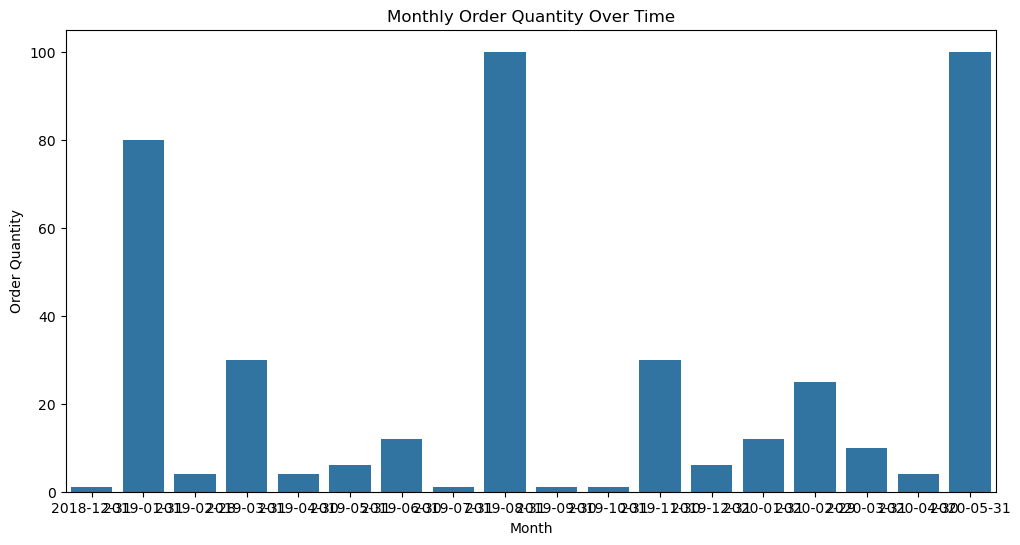

In [10]:
#Plotting monthly_df
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_df.index, y=monthly_df['Order_Quantity'])
plt.title('Monthly Order Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Order Quantity')
plt.show()

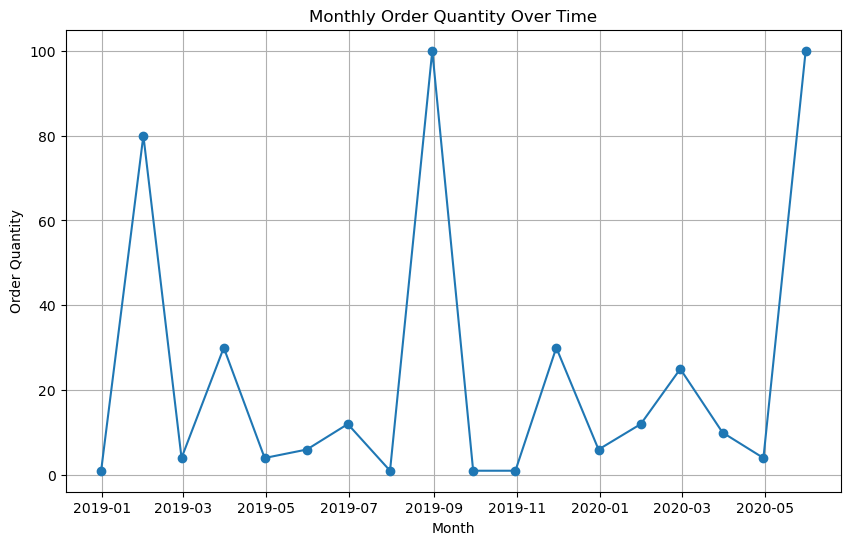

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_df.index, monthly_df['Order_Quantity'], marker='o', linestyle='-')
plt.title('Monthly Order Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Order Quantity')
plt.grid(True)
plt.show()

In [12]:
pivot_df = pd.pivot_table(df, values='Order_Quantity', index=['Checkout_Date', 'Day', 'Month'], aggfunc='sum').reset_index()
print(pivot_df.head())

  Checkout_Date        Day     Month  Order_Quantity
0    2018-12-04    Tuesday  December               2
1    2018-12-05  Wednesday  December              79
2    2018-12-06   Thursday  December             422
3    2018-12-07     Friday  December             468
4    2018-12-08   Saturday  December             111


In [13]:
# Testing for Stationarity using adfuller
from statsmodels.tsa.stattools import adfuller
res = adfuller(pivot_df["Order_Quantity"])
adf_statistic = res[0]
p_value = res[1]

#Setting actual level of p for stationarity
actual_level = 0.05

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

# Checking if the p-value is less than or equal to the actual level
if p_value <= actual_level:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -10.147197874904464
p-value: 8.127120756465817e-18
The time series is stationary.


In [14]:
monthly_df = monthly_df.reset_index()

In [15]:
print(monthly_df.columns)

Index(['Checkout_Date', 'Order_Quantity', 'Day', 'Month'], dtype='object')


In [16]:
monthly_df=monthly_df[["Checkout_Date","Order_Quantity"]]

In [17]:
print(monthly_df.shape)

(18, 2)


# Spliting Data into train and test sets

In [18]:
# Calculating the number of months for training (e.g., 80%)
train_size = int(len(monthly_df) * 0.80)

# Splitting the data into training and testing sets
train = monthly_df.iloc[:train_size, :]
test = monthly_df.iloc[train_size:, :]

print(train.shape, test.shape)

(14, 2) (4, 2)


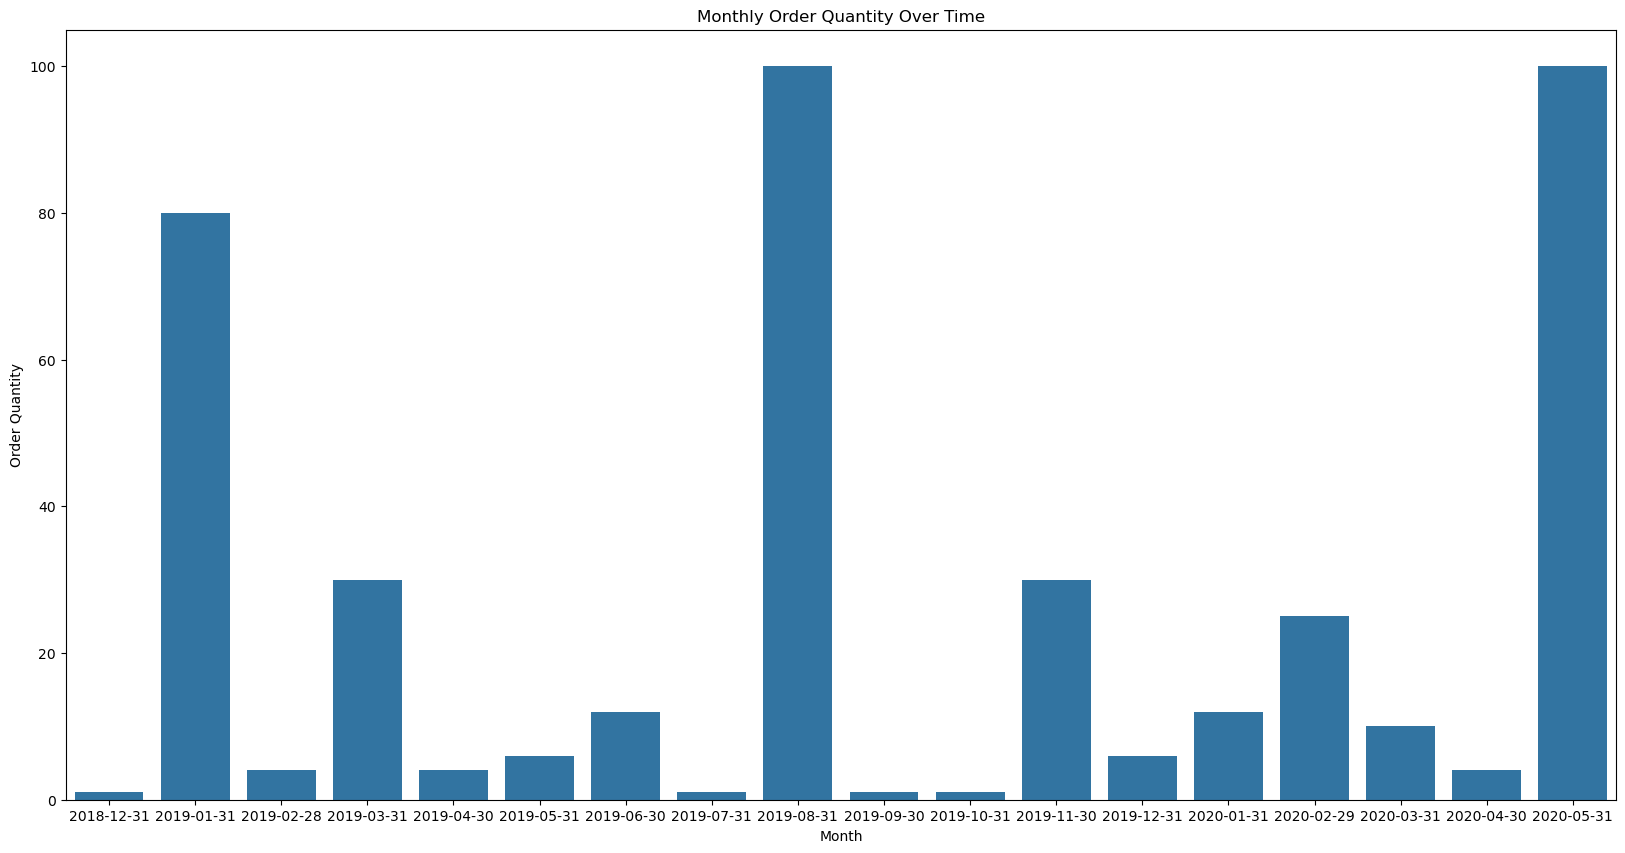

In [19]:
plt.figure(figsize=(20, 10))
sns.barplot(x=monthly_df['Checkout_Date'], y=monthly_df['Order_Quantity'])
plt.title('Monthly Order Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Order Quantity')
plt.show()

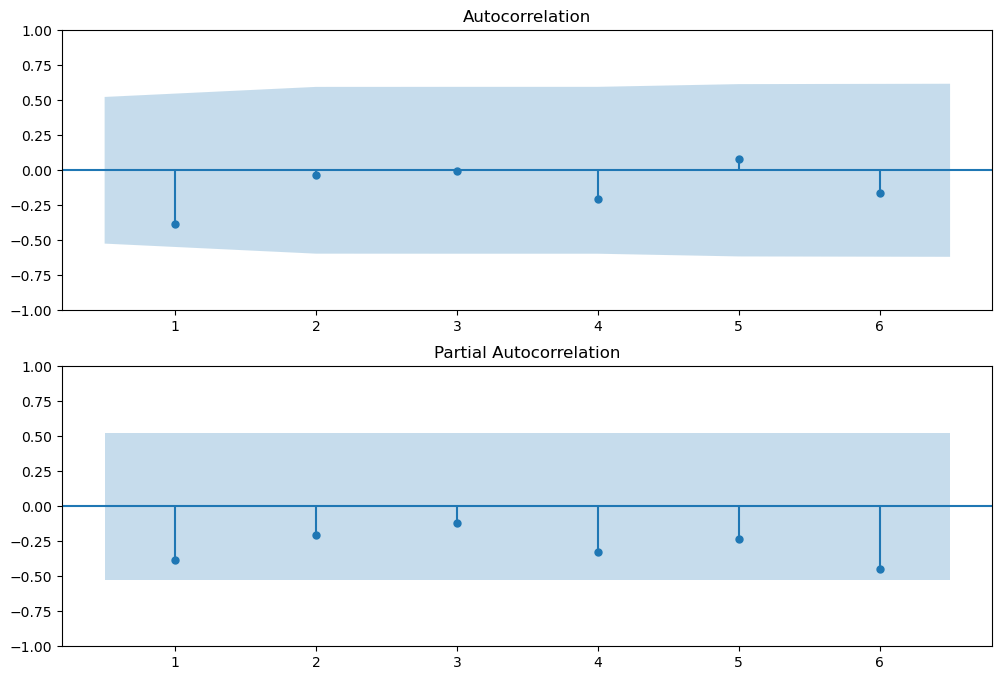

In [20]:
#Plotting autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12, 8))
plot_acf(train["Order_Quantity"], lags=6, zero=False, ax=ax1)
plot_pacf(train["Order_Quantity"], lags=6, zero=False, ax=ax2)
plt.show()

# MovingAverage(MA)

In [21]:
from statsmodels.tsa.arima.model import ARIMA
for q in range(3):
    # Fitting model
    model = ARIMA(train['Order_Quantity'], order=(0, 0, q))
    results = model.fit()

    # Checking model order and the AIC/BIC
    print(f"ARIMA Order: (0, 0, {q}), AIC: {results.aic}, BIC: {results.bic}")

ARIMA Order: (0, 0, 0), AIC: 139.04294684535137, BIC: 140.32106150458188
ARIMA Order: (0, 0, 1), AIC: 135.0616828178993, BIC: 136.9788548067451
ARIMA Order: (0, 0, 2), AIC: 136.8265253835108, BIC: 139.38275470197183


In [22]:
#Based on AIC value is low for Order(0,0,1) is best for fitting model
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Order_Quantity'],order=(0,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                   14
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -64.531
Date:                Mon, 08 Jan 2024   AIC                            135.062
Time:                        20:34:06   BIC                            136.979
Sample:                             0   HQIC                           134.884
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.9072      1.843     11.344      0.000      17.295      24.519
ma.L1         -0.9993     85.464     -0.012      0.991    -168.506     166.507
sigma2       486.8568   4.16e+04      0.012      0.991    -8.1e+04     8.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.80   Prob(JB):                         0.80
Heteroskedasticity (H):               0.31   Skew:                             0.29
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Checking mean forecasted values
print("Mean Forecasted Values:")
print(mean_forecast)

# Checking confidence intervals
print("\nConfidence Intervals:")
print(confidence_intervals)

Mean Forecasted Values:
14    33.642244
15    22.839064
16    20.873960
17    20.873960
18    20.873960
19    20.873960
20    20.873960
21    20.873960
22    20.873960
23    20.873960
24    20.873960
25    20.873960
Name: predicted_mean, dtype: float64

Confidence Intervals:
    lower Order_Quantity  upper Order_Quantity
14            -10.978220             78.262708
15            -34.098946             79.777075
16            -36.378557             78.126477
17            -36.378557             78.126477
18            -36.378557             78.126477
19            -36.378557             78.126477
20            -36.378557             78.126477
21            -36.378557             78.126477
22            -36.378557             78.126477
23            -36.378557             78.126477
24            -36.378557             78.126477
25            -36.378557             78.126477


<Axes: >

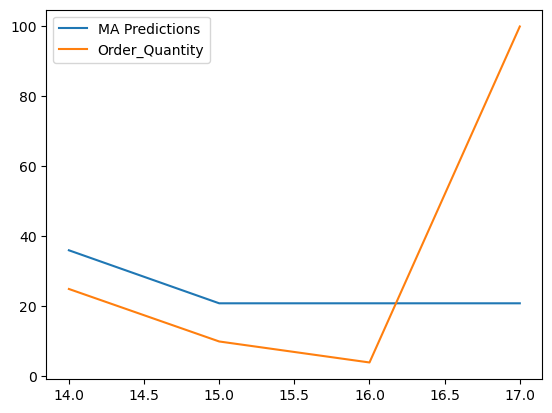

In [24]:
# Making predictions on the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = model.predict(start=start, end=end).rename('MA Predictions')
predictions.plot(legend=True)
test['Order_Quantity'].plot(legend=True)

In [25]:
monthly_df["Order_Quantity"].mean()

23.72222222222222

In [26]:
model2=ARIMA(monthly_df['Order_Quantity'],order=(0,0,1))
model2=model2.fit()
test.tail()

,Checkout_Date,Order_Quantity
14,2020-02-29,25
15,2020-03-31,10
16,2020-04-30,4
17,2020-05-31,100


2021-05-31   -23.946853
2021-06-30    20.610581
2021-07-31    20.610581
2021-08-31    20.610581
2021-09-30    20.610581
2021-10-31    20.610581
2021-11-30    20.610581
2021-12-31    20.610581
2022-01-31    20.610581
2022-02-28    20.610581
2022-03-31    20.610581
2022-04-30    20.610581
Freq: M, Name: MA Predictions, dtype: float64


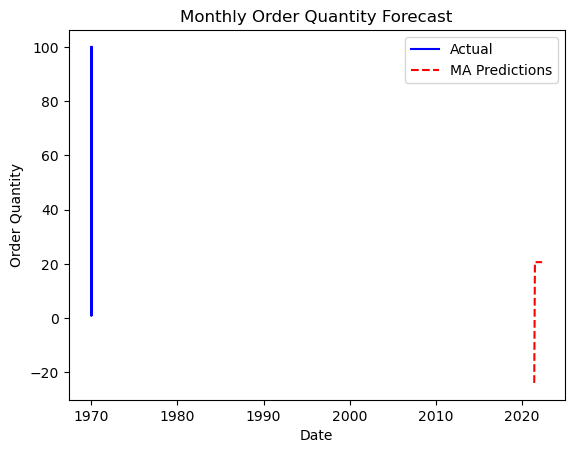

In [27]:
future_months = pd.date_range(start='2021-05-16', end='2022-05-15', freq='M')

# Forecasting next 12 months
predictions = model2.predict(start=len(monthly_df), end=len(monthly_df) + 11).rename('MA Predictions')

# Ensuring the length of future_months matches the length of predictions
future_months = future_months[:len(predictions)]

# Assigning the index to predictions
predictions.index = future_months

# Print and ploting the predictions
print(predictions)

# Ploting actual values
plt.plot(monthly_df['Order_Quantity'], label='Actual', color='blue')

# Ploting MA predictions for the next 12 months
plt.plot(predictions.index, predictions, color='red', linestyle='--', label='MA Predictions')

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.title('Monthly Order Quantity Forecast')
plt.legend()
plt.show()

# ARIMA

In [28]:
# from statsmodels.tsa.arima.model import ARIMA
for d in range(4):
    for q in range(4):
        try:
            model = ARIMA(train['Order_Quantity'], order=(0, d, q))
            results = model.fit()
            print(f"ARIMA Order: (0, {d}, {q}), AIC: {results.aic}, BIC: {results.bic}")
        except:
            print(0,d,q, None, None)
            

ARIMA Order: (0, 0, 0), AIC: 139.04294684535137, BIC: 140.32106150458188
ARIMA Order: (0, 0, 1), AIC: 135.0616828178993, BIC: 136.9788548067451
ARIMA Order: (0, 0, 2), AIC: 136.8265253835108, BIC: 139.38275470197183
ARIMA Order: (0, 0, 3), AIC: 136.6473526711261, BIC: 139.8426393192024
ARIMA Order: (0, 1, 0), AIC: 141.41333975137312, BIC: 141.97828910883464
ARIMA Order: (0, 1, 1), AIC: 132.99913732277824, BIC: 134.12903603770133
ARIMA Order: (0, 1, 2), AIC: 132.49707760340215, BIC: 134.19192567578676
ARIMA Order: (0, 1, 3), AIC: 133.77604835975083, BIC: 136.03584578959698
ARIMA Order: (0, 2, 0), AIC: 144.84719847440698, BIC: 145.33210512419498
ARIMA Order: (0, 2, 1), AIC: 136.19443661343735, BIC: 137.16424991301335
ARIMA Order: (0, 2, 2), AIC: 130.9570867455868, BIC: 132.4118066949508
ARIMA Order: (0, 2, 3), AIC: 132.23634048022296, BIC: 134.17596707937497
ARIMA Order: (0, 3, 0), AIC: 146.09981038854613, BIC: 146.4977056613445
ARIMA Order: (0, 3, 1), AIC: 138.0914813789303, BIC: 138.88

In [29]:
#Based on aic,bic values order(0,3,3) is good for model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Order_Quantity'], order=(0, 3, 3))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                   14
Model:                 ARIMA(0, 3, 3)   Log Likelihood                 -61.323
Date:                Mon, 08 Jan 2024   AIC                            130.646
Time:                        20:34:08   BIC                            132.238
Sample:                             0   HQIC                           129.643
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.8495    321.694     -0.009      0.993    -633.358     627.659
ma.L2          2.8378    617.887      0.005      0.996   -1208.198    1213.874
ma.L3         -0.9874    324.685     -0.003      0.998    -637.359     635.384
sigma2      1381.1694   4.54e+05      0.003      0.998   -8.89e+05    8.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.91   Prob(JB):                         0.89
Heteroskedasticity (H):               0.44   Skew:                             0.16
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Forecasting future values
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

print("Mean Forecasted Values:")
print(mean_forecast)

print("\nConfidence Intervals:")
print(confidence_intervals)


Mean Forecasted Values:
14    18.478629
15    16.364499
16    14.197128
17    11.976516
18     9.702664
19     7.375570
20     4.995236
21     2.561661
22     0.074846
23    -2.465211
24    -5.058508
25    -7.705046
Name: predicted_mean, dtype: float64

Confidence Intervals:
    lower Order_Quantity  upper Order_Quantity
14            -64.937053            101.894311
15            -70.937323            103.666321
16            -80.907515            109.301771
17            -95.506433            119.459466
18           -114.862788            134.268116
19           -138.761368            153.512509
20           -166.869583            176.860056
21           -198.870822            203.994145
22           -234.509812            234.659504
23           -273.594458            268.664036
24           -315.983943            305.866927
25           -361.575608            346.165516


<Axes: >

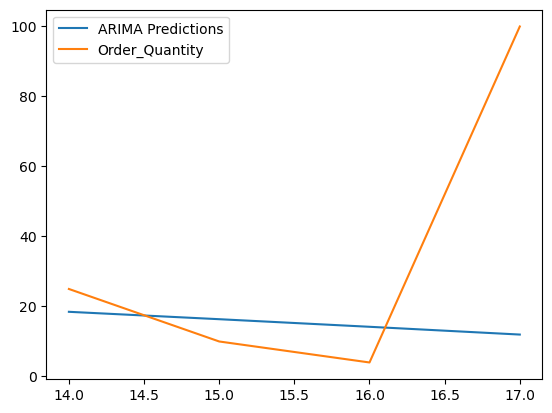

In [31]:
# Making predictions on the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end).rename('ARIMA Predictions')
predictions.plot(legend=True)
test['Order_Quantity'].plot(legend=True)

In [32]:
results2=ARIMA(monthly_df['Order_Quantity'],order=(0,3,3))
results2=results2.fit()
test.tail()

,Checkout_Date,Order_Quantity
14,2020-02-29,25
15,2020-03-31,10
16,2020-04-30,4
17,2020-05-31,100


2021-05-31     90.710524
2021-06-30    147.355096
2021-07-31    208.251033
2021-08-31    273.398334
2021-09-30    342.797000
2021-10-31    416.447031
2021-11-30    494.348426
2021-12-31    576.501186
2022-01-31    662.905311
2022-02-28    753.560801
2022-03-31    848.467655
2022-04-30    947.625873
Freq: M, Name: MA Predictions, dtype: float64


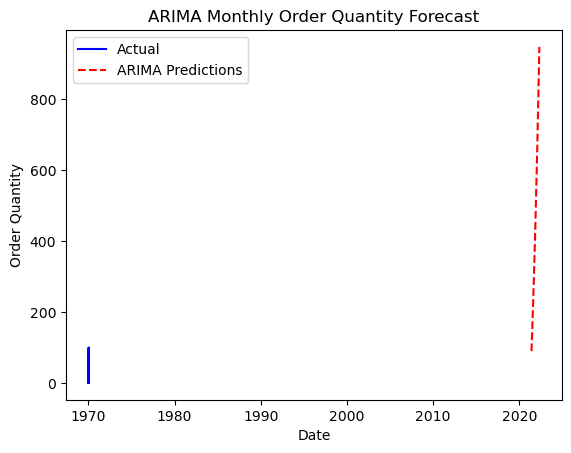

In [33]:
ar_months = pd.date_range(start='2021-05-16', end='2022-05-15', freq='M')

# Forecast the next 12 months
predictions = results2.predict(start=len(monthly_df), end=len(monthly_df) + 11).rename('MA Predictions')

# Ensuring the length of future_months matches the length of predictions
ar_months = ar_months[:len(predictions)]

# Assigning the index to predictions
predictions.index = ar_months

# Print and ploting the predictions
print(predictions)

# Plot actual values
plt.plot(monthly_df['Order_Quantity'], label='Actual', color='blue')

# Ploting MA predictions for the next 12 months
plt.plot(predictions.index, predictions, color='red', linestyle='--', label='ARIMA Predictions')

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.title('ARIMA Monthly Order Quantity Forecast')
plt.legend()
plt.show()

# SARIMA

In [34]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [41]:
from pmdarima.arima import auto_arima
sarima_model = auto_arima(train['Order_Quantity'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=143.410, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=140.665, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=141.413, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=138.702, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=140.665, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=142.665, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=138.216, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=140.201, Time=0.14 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=140.201, Time=0.13 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=142.201, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=139.863, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=in

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sar_model=SARIMAX(train['Order_Quantity'],order=(2,1,0),seasonal_order=(0,0,0,12))
sar_res=sar_model.fit()
sar_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                   14
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -65.181
Date:                Mon, 08 Jan 2024   AIC                            136.362
Time:                        20:43:05   BIC                            138.057
Sample:                             0   HQIC                           136.014
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9091      0.467     -1.948      0.051      -1.824       0.006
ar.L2         -0.4298      0.439     -0.979      0.328      -1.290       0.431
sigma2      1234.9530    386.608      3.194      0.001     477.216    1992.690
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 5.92
Prob(Q):                              0.83   Prob(JB):                         0.05
Heteroskedasticity (H):               0.50   Skew:                             1.46
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

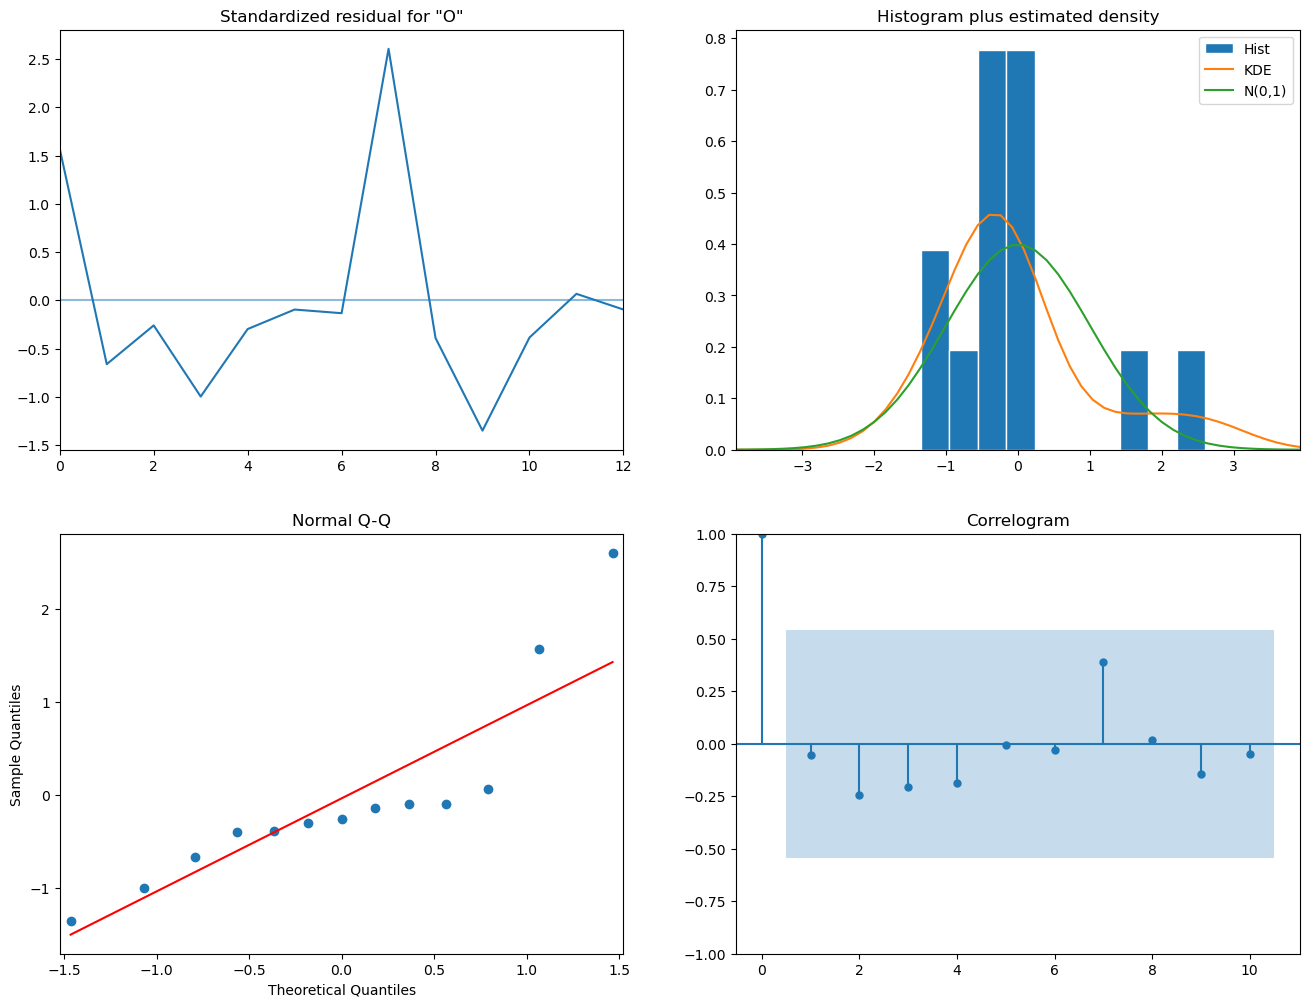

In [44]:
sar_res.plot_diagnostics(figsize=(16, 12))
plt.show()

<Axes: >

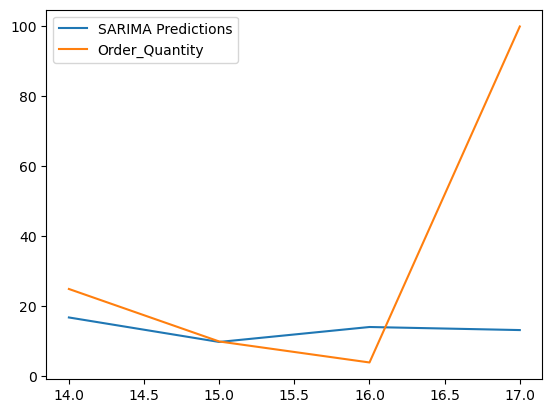

In [45]:
start=len(train)
end=len(train)+len(test)-1
pred1=sar_res.predict(start=start,end=end).rename('SARIMA Predictions')
pred1.plot(legend=True)
test['Order_Quantity'].plot(legend=True)

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Order_Quantity'].mean()
rmse=sqrt(mean_squared_error(pred1,test['Order_Quantity']))
print(rmse)

43.85446789093414


In [49]:
sar_res2=SARIMAX(train['Order_Quantity'],order=(2,1,0),Seasonal_Order=(0,0,0,12))
sar_res2=sar_res2.fit()

14    16.861593
15     9.863015
16    14.135577
17    13.259726
18    12.219443
19    13.541613
20    12.786809
21    12.904668
22    13.121967
23    12.873765
24    13.005997
25    12.992474
Name: predicted_mean, dtype: float64


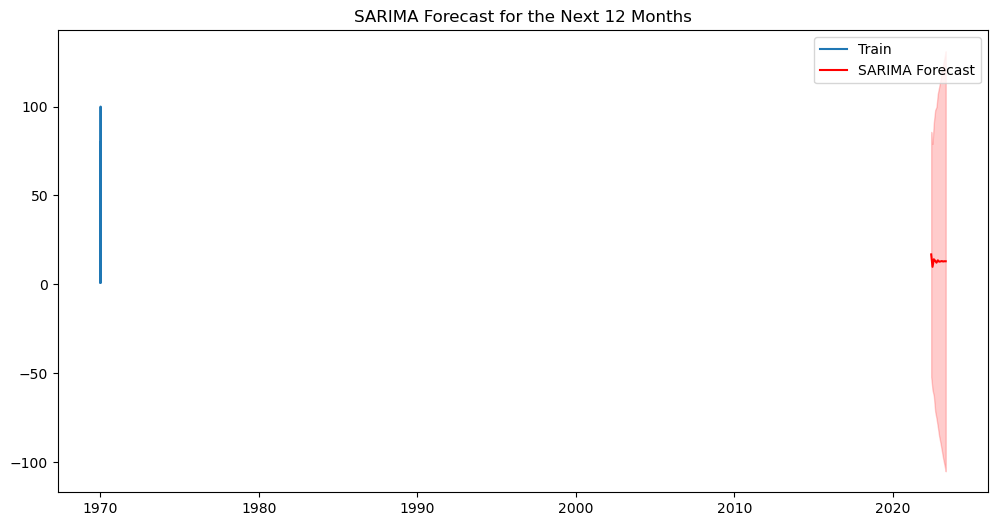

In [51]:
sar_future_months = pd.date_range(start='2021-05-16', end='2022-05-15', freq='M')

# Forecast using the trained SARIMA model
sarima_predictions = sar_res2.get_forecast(steps=12)
sarima_predictions_index = pd.date_range(start=sar_future_months[-1], periods=13, freq='M')[1:]
sarima_predictions_conf_int = sarima_predictions.conf_int()

# Print and ploting the forecast
print(sarima_predictions.predicted_mean)

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Order_Quantity'], label='Train')
plt.plot(sarima_predictions_index, sarima_predictions.predicted_mean, color='red', label='SARIMA Forecast')
plt.fill_between(sarima_predictions_index, sarima_predictions_conf_int.iloc[:, 0], sarima_predictions_conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMA Forecast for the Next 12 Months')
plt.legend()
plt.show()
